Task 1

In [2]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

#reading the dataset from a CSV file
#survey_reader = Table.read_table('/content/sample_data/choices_part.csv')
survey_reader = Table.read_table('/content/sample_data/multipleChoiceResponses.csv')

#relabeling columns as readable format
survey_reader = survey_reader.relabeled('Q1','Gender')
survey_reader = survey_reader.relabeled('Q9','Annual_Salary')
#removing the row with survey questions
survey_reader = survey_reader.exclude(0)


#removing values which are unclear
#gender values
survey_reader = survey_reader.select('Gender','Annual_Salary').where('Gender',are.not_containing('Prefer'))
#salary values
survey_reader = ((survey_reader.select('Gender','Annual_Salary')).where('Annual_Salary',are.not_containing('nan'))).where('Annual_Salary',are.not_containing('I do not wish to disclose my approximate yearly compensation'))

#performing data cleaning 
survey_reader['Annual_Salary'] = survey_reader.apply(lambda x: '500000' if x=='500,000+' else x,'Annual_Salary')
survey_reader['Annual_Salary'] = survey_reader.apply(lambda x: x.replace('-','000-'),'Annual_Salary')
survey_reader['Annual_Salary'] = survey_reader.apply(lambda x: x.replace(',', ''),'Annual_Salary')
survey_reader['Annual_Salary'] = survey_reader.apply(lambda x: np.mean([int(i) for i in x.split('-')]),'Annual_Salary')


#calculating median for the salaries grouped by gender - Male and Female
print("Median of Annual Salary (in USD) for Male is: "+str(np.median((survey_reader.where('Gender','Male')).column(1))))
print("Median of Annual Salary (in USD) for Female is: "+str(np.median((survey_reader.where('Gender','Female')).column(1))))

observed_statistic = abs(np.median(survey_reader.where('Gender','Male').column(1)) - np.median(survey_reader.where('Gender','Female').column(1)))

print('Observed difference in Salary (in USD) from original data: '+ str(observed_statistic))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Median of Annual Salary (in USD) for Male is: 35000.0
Median of Annual Salary (in USD) for Female is: 25000.0
Observed difference in Salary from original data: 10000.0


Task 2

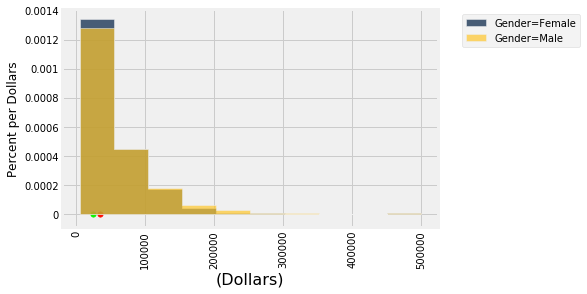

In [40]:
#histogram with Annaul Salaries for both genders
survey_reader.hist('Annual_Salary',unit='Dollars',group='Gender')
#plotting the Median of Salary for both genders
plots.scatter(np.median(survey_reader.where('Gender','Male').column(1)), 0, color='#ff1004', s=30)
plots.scatter(np.median(survey_reader.where('Gender','Female').column(1)), 0, color='#0ef506', s=30)

Task 3



Null Hypothesis - No significant difference in the median of salary for both males and females

Alterative Hypothesis - there will be significant Difference will be present between males and females

Statistic - Absolute difference of median of salary of males and females from the sample derived

In [0]:
def MakeSample(survey_reader,n):
    #finding males & females and ratio
    x = survey_reader.where('Gender',are.equal_to('Male'))
    y = survey_reader.where('Gender',are.equal_to('Female'))
    r = round(x.num_rows/y.num_rows)

    #males & females in sample with same ratio as dataset
    females = round(n/(r+1))
    males = n - females

    #generating random sample
    Sample = x.sample(k=males).append(y.sample(k=females))
    return(Sample)


In [38]:
#running for one sample 
sample_derived = MakeSample(survey_reader,500)
median_of_sample_derived = np.median(sample_derived.column('Annual_Salary'))

female_median_sample_derived = np.median(sample_derived.where('Gender',are.equal_to('Female')).column('Annual_Salary'))
male_median_sample_derived = np.median(sample_derived.where('Gender',are.equal_to('Male')).column('Annual_Salary'))

sample_statistic = abs(male_median_sample_derived-female_median_sample_derived)

print("The median of the Sample is: ",median_of_sample_derived)
print("The median Annual Salary (in USD) of  Females in Sample is: ",female_median_sample_derived)
print("The median Annual Salary (in USD) of  Males in Sample is: ",male_median_sample_derived)
print("The absolute diff in median Annual Salary (in USD) of Male to Female in Sample is: ",sample_statistic)

The median of the Sample is:  25000.0
The median Annual Salary (in USD) of  Females in Sample is:  15000.0
The median Annual Salary (in USD) of  Males in Sample is:  35000.0
The absolute diff in median Annual Salary (in USD) of Male to Female in Sample is:  20000.0


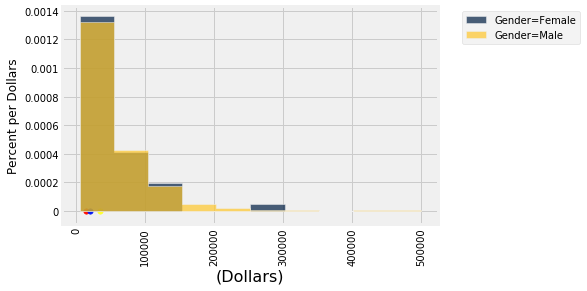

In [39]:
sample_derived.hist('Annual_Salary',unit ='Dollars',group='Gender')
plots.scatter(female_median_sample_derived, 0, color='#ff1004', s=30)
plots.scatter(male_median_sample_derived, 0, color='#ffff2f', s=30)
plots.scatter(sample_statistic, 0,color='#061cf5',s=30 )

In [0]:
#No of simulations
simulation = 10000
#to store median differences for n samples
median_difference = make_array()

#simulating
for i in np.arange(simulation):
  sample1 = MakeSample(survey_reader,500)
  female_median_sample_derived = np.median(sample1.where('Gender',are.equal_to('Female')).column('Annual_Salary'))
  male_median_sample_derived = np.median(sample1.where('Gender',are.equal_to('Male')).column('Annual_Salary'))
  median_difference = np.append(median_difference,abs(female_median_sample_derived-male_median_sample_derived))


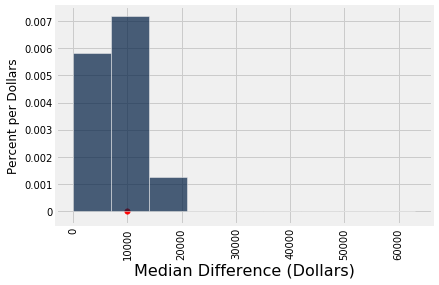

In [36]:
#plotting the simulation results with observed statistic
(Table().with_columns('Median Difference',median_difference)).hist(bins=np.arange(0,70000,7000),unit='Dollars')
plots.scatter(observed_statistic,0,color='red',s=30)

In [51]:
#Calculating P-Value
np.count_nonzero(median_difference <= observed_statistic) / simulation

0.9099

In [0]:
#simulating A/B testing

shuffle_median_difference = make_array()
simulation_a_b_testing = 10000

for i in np.arange(simulation_a_b_testing):
  #shuffling the columns for gender and making a new table with them
  shuffled_column = survey_reader.sample(with_replacement = False).column('Gender')
  shuffled_table = survey_reader.select('Annual_Salary').with_column('Shuffled_Gender',shuffled_column)
  
  #finding median of males and females for shuffled table
  shuffle_female_median = np.median(shuffled_table.where('Shuffled_Gender',are.equal_to('Female')).column('Annual_Salary'))
  shuffle_male_median = np.median(shuffled_table.where('Shuffled_Gender',are.equal_to('Male')).column('Annual_Salary'))
  shuffle_median_difference = np.append(shuffle_median_difference,abs(shuffle_male_median-shuffle_female_median))


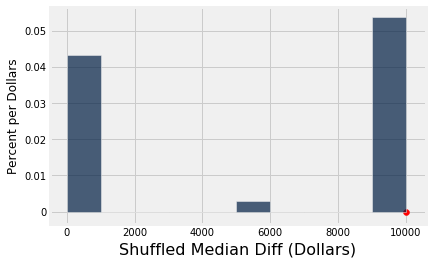

In [57]:
#plotting a histogram for A/B Testing
Table().with_column('Shuffled Median Diff',shuffle_median_difference).hist(unit='Dollars')
plots.scatter(observed_statistic, 0, color='red', s=35)

95% confidence interval for the samples are between: 25000.0 and 35000.0


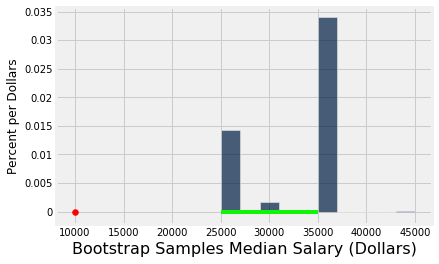

In [60]:
#Executing Bootstrap
#original sample
bs_sample = survey_reader.sample(500,with_replacement=False)
#array to medians
bs_median_arr = make_array()

#iterating to generate 10000 samples from the original sample and calculating medianfor each sample
for i in np.arange(10000):
  sample1 = bs_sample.sample() 
  bs_median_arr = np.append(bs_median_arr,np.percentile(sample1.column(1),50))

#finding confidence intervals
left = np.percentile(bs_median_arr,2.5)
right = np.percentile(bs_median_arr,97.5)
print('95% confidence interval for the samples are between: '+str(left) + " and "+str(right))

#plotting the values
bs_table = Table().with_column('Bootstrap Samples Median Salary',bs_median_arr)
bs_table.hist(unit='Dollars')
plots.scatter(observed_statistic, 0, color='red', s=35)
plots.plot(np.array([left, right]), np.array([0, 0]), color='#0ef506')

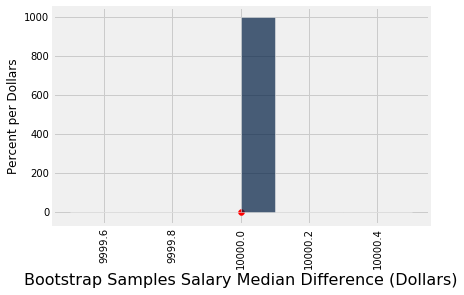

In [59]:
bs_median_diff = Table().with_columns('Median Difference',median_difference).sample(5000,with_replacement=False)
bs_median_diff_arr = make_array()

for i in np.arange(10000):
  sample1 = bs_median_diff.sample()
  bs_median_diff_arr = np.append(bs_median_diff_arr,np.percentile(sample1.column(0),50))


Table().with_columns('Bootstrap Samples Salary Median Difference',bs_median_diff_arr).hist(unit='Dollars')
plots.scatter(observed_statistic, 0, color='red', s=35)